In [104]:
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import GaussianNB
from skmultiflow.trees import HoeffdingTreeClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from skmultiflow.drift_detection import DDM
from skmultiflow.drift_detection import EDDM
from skmultiflow.drift_detection import ADWIN
from skmultiflow.drift_detection import HDDM_A
from skmultiflow.drift_detection import HDDM_W

from tqdm import tqdm
import itertools
import random
import seaborn as sns
from sklearn.decomposition import PCA

from scipy import stats
from scipy.stats import mannwhitneyu
from math import log2
from sklearn.metrics.pairwise import manhattan_distances
from scipy.spatial.distance import chebyshev
from scipy.spatial.distance import kulsinski
from scipy.spatial.distance import cosine
from scipy.spatial.distance import sqeuclidean

In [98]:
def kl_divergence(p, q):
    return sum(p[0][i] * log2(p[0][i]/q[0][i]) for i in range(len(p[0])))

In [99]:
def bhattacharyya(p, q):
    return -np.log(sum(np.square(p[0][i]*1.0*q[0][i]) for i in range(len(p[0]))))

In [66]:
def bootstrapping(X_train, bootstrapping_samples, pca=None):
    # Extract distributions of 50 random training subsets
    distributions_bootstrapping = []
    for i in tqdm(range(0, bootstrapping_samples)):
        # generate random number between 0 and length_of_train-length_of_test in order to have a sample of size length_of_test
        rand = random.randint(0,len(X_train)-length_of_test)
        # extract the distribution from the training samples random number:random number + length_of_test by means of histogram
        if pca is not None:
            bootstrapping_input = pca.transform(X_train[rand:rand+length_of_test])
        else:
            bootstrapping_input = X_train[rand:rand+length_of_test]
        dist = sns.distplot(bootstrapping_input).get_lines()[0].get_data()[1]
        # store distribution
        distributions_bootstrapping.append(dist)
        plt.close()
    return distributions_bootstrapping

In [59]:
def kdqtrees_bootstrapping(distrib_X_train, distrib_X_test, distributions_bootstrapping, distance):
    
    # option to choose the similarity distance
    
    if(distance == 'kl_divergence'):
        similarity_metric = kl_divergence
    elif(distance == 'manhattan'):
        similarity_metric = manhattan_distances
    elif(distance == 'chebyshev'):
        similarity_metric = chebyshev
    elif(distance == 'kulsinski'):
        similarity_metric = kulsinski
    elif(distance == 'cosine'):
        similarity_metric = cosine
    elif(distance == 'squared_euclidean'):
        similarity_metric = sqeuclidean
    elif(distance == 'bhattacharyya'):
        similarity_metric = bhattacharyya
    
    # Bootstrapping technique to define critical region
    
    dist_bootstrapping = []
    
    # Calculate similarity distance between training set and each of the 50 training subsets
    for i in range(0, len(distributions_bootstrapping)):
        dist_bootstrapping.append(similarity_metric([distrib_X_train], [distributions_bootstrapping[i]]))
    
    
    # Define Critical Region
    critical_region = np.max(dist_bootstrapping)
    
    # Detect Drifts between train and test
    
    drift_batch = None
    
    # Calculate distance between train and test distributions
    
    similarity_metric_train_test = similarity_metric([distrib_X_train], [distrib_X_test])
    
    if(similarity_metric_train_test>critical_region):
        print(distance + " : Drift Detected" )
        return 1
    else:
        return 0

In [50]:
def compute_metric_false_positive(array_batches, drift_start):
        
    if(len(array_batches)>0): 
        
        if(len([x for x in array_batches if x<drift_start])>0):
            return(len([x for x in array_batches if x<drift_start])/drift_start)
        else:
            return 0
        
    else:
        return 'nothing_detected'

In [60]:
def ede_drift_detector(distrib_X_train, distrib_X_test, statistical_test):

    if(statistical_test == 'ks'):
        stat_test = stats.kstest
    elif(statistical_test == 'mw'):
        stat_test = stats.mannwhitneyu
    
    v, p = stat_test(distrib_X_train, distrib_X_test)
        
    
    if(p<=0.05):
        print("Reject Null Hypothesis according to KS statistical test")
        return 1
    else:
        return 0

In [47]:
def compute_metric_latency(array_batches, no_batches_with_drift, drift_start):
    
    if(len(array_batches)>0):  
        #print(np.array(array_pr)>=drift_type_start)
        #print(np.argwhere(np.array(array_pr)>=drift_type_start).size==0)
        
        if(np.argwhere(np.array(array_batches)>=drift_start).size==0):
            latency_score = 'nothing_detected' 
        else:
            batch_drift_detected = array_batches[np.argwhere(np.array(array_batches)>=drift_start)[0][0]]
            latency_score = (batch_drift_detected - drift_start)/no_batches_with_drift
        return latency_score
    else:
        return 'nothing_detected'

In [2]:
def drift_detect_function(drift_detector, y_true, y_pred, no_batches):
    batches_with_drift = []
    for i in range(0, no_batches):
        label_difference = abs(y_true[i] - y_pred[i])
        #print(label_difference)
        
        for j in tqdm(range(0, len(label_difference))):
            drift_detector.add_element(list(label_difference)[j])

            if(drift_detector.detected_change()):
                batches_with_drift.append(i)
    return batches_with_drift

In [3]:
# ADWIN has: 1 for correct prediction and 0 for incorrect prediction
def drift_detect_function_ADWIN(drift_detector, y_true, y_pred, no_batches):
    
    batches_with_drift = []
    for i in range(0, no_batches):
        label_difference = abs(y_true[i] - y_pred[i])
        label_difference_final = 1 - label_difference
    
        for j in tqdm(range(0, len(label_difference_final))):
            drift_detector.add_element(list(label_difference_final)[j])
            if(drift_detector.detected_change()):
                batches_with_drift.append(i)
    return batches_with_drift

In [4]:
data_airlines = arff.loadarff('../airlines.arff')
df_airlines = pd.DataFrame(data_airlines[0])
df_airlines

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,b'CO',269.0,b'SFO',b'IAH',b'3',15.0,205.0,b'1'
1,b'US',1558.0,b'PHX',b'CLT',b'3',15.0,222.0,b'1'
2,b'AA',2400.0,b'LAX',b'DFW',b'3',20.0,165.0,b'1'
3,b'AA',2466.0,b'SFO',b'DFW',b'3',20.0,195.0,b'1'
4,b'AS',108.0,b'ANC',b'SEA',b'3',30.0,202.0,b'0'
...,...,...,...,...,...,...,...,...
539378,b'CO',178.0,b'OGG',b'SNA',b'5',1439.0,326.0,b'0'
539379,b'FL',398.0,b'SEA',b'ATL',b'5',1439.0,305.0,b'0'
539380,b'FL',609.0,b'SFO',b'MKE',b'5',1439.0,255.0,b'0'
539381,b'UA',78.0,b'HNL',b'SFO',b'5',1439.0,313.0,b'1'


### Encode Labels

In [9]:
labelencoder = LabelEncoder()
df_airlines['Delay'] = labelencoder.fit_transform(df_airlines['Delay'])
df_airlines

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,b'CO',269.0,b'SFO',b'IAH',b'3',15.0,205.0,1
1,b'US',1558.0,b'PHX',b'CLT',b'3',15.0,222.0,1
2,b'AA',2400.0,b'LAX',b'DFW',b'3',20.0,165.0,1
3,b'AA',2466.0,b'SFO',b'DFW',b'3',20.0,195.0,1
4,b'AS',108.0,b'ANC',b'SEA',b'3',30.0,202.0,0
...,...,...,...,...,...,...,...,...
539378,b'CO',178.0,b'OGG',b'SNA',b'5',1439.0,326.0,0
539379,b'FL',398.0,b'SEA',b'ATL',b'5',1439.0,305.0,0
539380,b'FL',609.0,b'SFO',b'MKE',b'5',1439.0,255.0,0
539381,b'UA',78.0,b'HNL',b'SFO',b'5',1439.0,313.0,1


# Feature Analysis

In [10]:
x = np.arange(len(df_airlines))

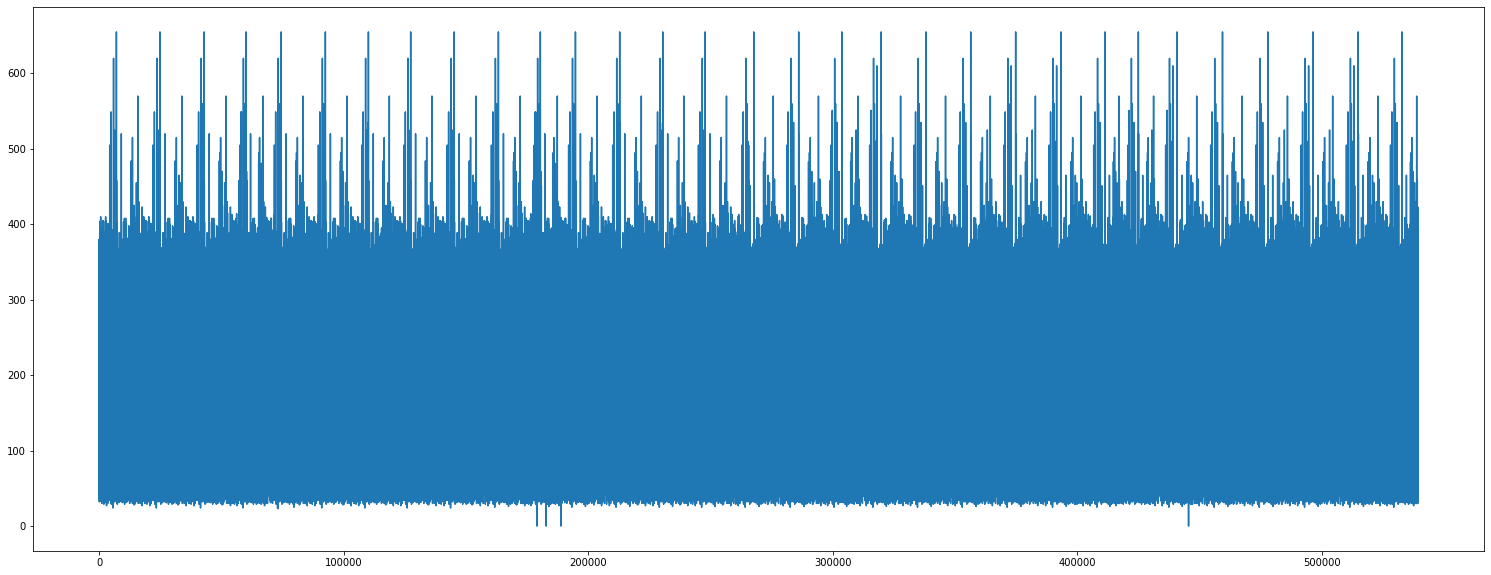

In [11]:
plt.figure(figsize=(26, 10))
plt.plot(x, df_airlines.Length)

### Feature Cardinality Analysis

In [12]:
len(df_airlines.Airline.value_counts())

18

In [13]:
len(df_airlines.AirportFrom.value_counts())

293

In [14]:
len(df_airlines.AirportTo.value_counts())

293

In [15]:
df_airlines[(df_airlines.Flight == 269.0) & (df_airlines.Airline == list(df_airlines.Airline)[0])]

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,b'CO',269.0,b'SFO',b'IAH',b'3',15.0,205.0,1
17613,b'CO',269.0,b'SFO',b'IAH',b'4',15.0,205.0,1
35660,b'CO',269.0,b'SFO',b'IAH',b'5',15.0,205.0,1
53800,b'CO',269.0,b'SFO',b'IAH',b'6',15.0,203.0,1
68078,b'CO',269.0,b'SFO',b'IAH',b'7',15.0,203.0,1
85190,b'CO',269.0,b'SFO',b'IAH',b'1',15.0,205.0,1
103138,b'CO',269.0,b'SFO',b'IAH',b'2',15.0,205.0,1
120388,b'CO',269.0,b'SFO',b'IAH',b'3',15.0,205.0,1
137921,b'CO',269.0,b'SFO',b'IAH',b'4',15.0,205.0,1
155977,b'CO',269.0,b'SFO',b'IAH',b'5',15.0,205.0,1


Issue: Airport From and Airport To have 293 different values each, which makes them high cardinal features. This results in adding almost 600 new features through One Hot Encoding, which could make the model suffer from the curse of dimensionality. 

Solution: we can remove AirportTo and AirportFrom, since the flight number + airline is the same for each source and destination. However, the flight number can be the same for multiple airlines, so Airline should not be removed.

### Remove high cardinality features

In [16]:
df_airlines = df_airlines.drop(['AirportFrom', 'AirportTo'], axis = 1)
df_airlines

,Airline,Flight,DayOfWeek,Time,Length,Delay
0,b'CO',269.0,b'3',15.0,205.0,1
1,b'US',1558.0,b'3',15.0,222.0,1
2,b'AA',2400.0,b'3',20.0,165.0,1
3,b'AA',2466.0,b'3',20.0,195.0,1
4,b'AS',108.0,b'3',30.0,202.0,0
...,...,...,...,...,...,...
539378,b'CO',178.0,b'5',1439.0,326.0,0
539379,b'FL',398.0,b'5',1439.0,305.0,0
539380,b'FL',609.0,b'5',1439.0,255.0,0
539381,b'UA',78.0,b'5',1439.0,313.0,1


### One Hot Encoding on Airline

In [17]:
one_hot_encoded_data = pd.get_dummies(df_airlines, columns = ['Airline'])
df = one_hot_encoded_data
df

,Flight,DayOfWeek,Time,Length,Delay,Airline_b'9E',Airline_b'AA',Airline_b'AS',Airline_b'B6',Airline_b'CO',...,Airline_b'FL',Airline_b'HA',Airline_b'MQ',Airline_b'OH',Airline_b'OO',Airline_b'UA',Airline_b'US',Airline_b'WN',Airline_b'XE',Airline_b'YV'
0,269.0,b'3',15.0,205.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1558.0,b'3',15.0,222.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2400.0,b'3',20.0,165.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2466.0,b'3',20.0,195.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,108.0,b'3',30.0,202.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539378,178.0,b'5',1439.0,326.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
539379,398.0,b'5',1439.0,305.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
539380,609.0,b'5',1439.0,255.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
539381,78.0,b'5',1439.0,313.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Features Train & Test

In [26]:
df_features_train_test = df.drop(['DayOfWeek', 'Delay'], axis = 1)
df_features_train_test

,Flight,Time,Length,Airline_b'9E',Airline_b'AA',Airline_b'AS',Airline_b'B6',Airline_b'CO',Airline_b'DL',Airline_b'EV',...,Airline_b'FL',Airline_b'HA',Airline_b'MQ',Airline_b'OH',Airline_b'OO',Airline_b'UA',Airline_b'US',Airline_b'WN',Airline_b'XE',Airline_b'YV'
0,269.0,15.0,205.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1558.0,15.0,222.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2400.0,20.0,165.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2466.0,20.0,195.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,108.0,30.0,202.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539378,178.0,1439.0,326.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
539379,398.0,1439.0,305.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
539380,609.0,1439.0,255.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
539381,78.0,1439.0,313.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [27]:
df_labels_train_test = df['Delay']
df_labels_train_test

0         1
1         1
2         1
3         1
4         0
         ..
539378    0
539379    0
539380    0
539381    1
539382    1
Name: Delay, Length: 539383, dtype: int64

## Week

In [165]:
# the numbers here correspond to the exact moment when the second week starts and 
# the exact moment for each day of the week

In [28]:
# including Day 1 & 2 of the second week (Monday and Tuesday) into the training set
df_train_1 = df_features_train_test[85190:120388] 
df_labels_train_1 = df_labels_train_test[85190:120388]
df_train_1

,Flight,Time,Length,Airline_b'9E',Airline_b'AA',Airline_b'AS',Airline_b'B6',Airline_b'CO',Airline_b'DL',Airline_b'EV',...,Airline_b'FL',Airline_b'HA',Airline_b'MQ',Airline_b'OH',Airline_b'OO',Airline_b'UA',Airline_b'US',Airline_b'WN',Airline_b'XE',Airline_b'YV'
85190,269.0,15.0,205.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
85191,1558.0,15.0,222.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
85192,2400.0,20.0,165.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85193,2466.0,20.0,195.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85194,108.0,30.0,202.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120383,1740.0,1435.0,217.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
120384,2354.0,1435.0,250.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
120385,739.0,1439.0,223.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120386,225.0,1439.0,205.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [29]:
# extract data corresponding to Wednesday
df_test_wed = df_features_train_test[120388:137920]
df_labels_test_wed = df_labels_train_test[120388:137920]
df_test_wed

,Flight,Time,Length,Airline_b'9E',Airline_b'AA',Airline_b'AS',Airline_b'B6',Airline_b'CO',Airline_b'DL',Airline_b'EV',...,Airline_b'FL',Airline_b'HA',Airline_b'MQ',Airline_b'OH',Airline_b'OO',Airline_b'UA',Airline_b'US',Airline_b'WN',Airline_b'XE',Airline_b'YV'
120388,269.0,15.0,205.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
120389,1558.0,15.0,222.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
120390,2400.0,20.0,165.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120391,2466.0,20.0,195.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120392,108.0,30.0,202.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137915,2354.0,1435.0,250.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
137916,739.0,1439.0,223.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137917,225.0,1439.0,205.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
137918,328.0,1439.0,270.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [30]:
# extract data corresponding to Thursday
df_test_thu = df_features_train_test[137920:155976]
df_labels_test_thu = df_labels_train_test[137920:155976]
df_test_thu

,Flight,Time,Length,Airline_b'9E',Airline_b'AA',Airline_b'AS',Airline_b'B6',Airline_b'CO',Airline_b'DL',Airline_b'EV',...,Airline_b'FL',Airline_b'HA',Airline_b'MQ',Airline_b'OH',Airline_b'OO',Airline_b'UA',Airline_b'US',Airline_b'WN',Airline_b'XE',Airline_b'YV'
137920,2344.0,10.0,215.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
137921,269.0,15.0,205.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
137922,1558.0,15.0,222.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
137923,2400.0,20.0,165.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137924,2466.0,20.0,195.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155971,717.0,1439.0,220.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155972,739.0,1439.0,223.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155973,225.0,1439.0,205.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
155974,328.0,1439.0,270.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [31]:
# extract data corresponding to Friday
df_test_fri = df_features_train_test[155976:174115]
df_labels_test_fri = df_labels_train_test[155976:174115]
df_test_fri

,Flight,Time,Length,Airline_b'9E',Airline_b'AA',Airline_b'AS',Airline_b'B6',Airline_b'CO',Airline_b'DL',Airline_b'EV',...,Airline_b'FL',Airline_b'HA',Airline_b'MQ',Airline_b'OH',Airline_b'OO',Airline_b'UA',Airline_b'US',Airline_b'WN',Airline_b'XE',Airline_b'YV'
155976,2344.0,10.0,215.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
155977,269.0,15.0,205.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
155978,1558.0,15.0,222.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
155979,2400.0,20.0,165.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155980,2466.0,20.0,195.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174110,225.0,1439.0,205.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
174111,328.0,1439.0,270.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
174112,543.0,1439.0,208.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
174113,78.0,1439.0,313.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [32]:
# extract data corresponding to Saturday
df_test_sat = df_features_train_test[174115:188415]
df_labels_test_sat = df_labels_train_test[174115:188415]
df_test_sat

,Flight,Time,Length,Airline_b'9E',Airline_b'AA',Airline_b'AS',Airline_b'B6',Airline_b'CO',Airline_b'DL',Airline_b'EV',...,Airline_b'FL',Airline_b'HA',Airline_b'MQ',Airline_b'OH',Airline_b'OO',Airline_b'UA',Airline_b'US',Airline_b'WN',Airline_b'XE',Airline_b'YV'
174115,2344.0,10.0,215.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
174116,269.0,15.0,203.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
174117,1558.0,15.0,222.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
174118,2400.0,20.0,165.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174119,2466.0,20.0,195.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188410,480.0,1439.0,321.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
188411,739.0,1439.0,223.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
188412,225.0,1439.0,205.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
188413,328.0,1439.0,270.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [33]:
# extract data corresponding to Sunday
df_test_sun = df_features_train_test[188415:205551]
df_labels_test_sun = df_labels_train_test[188415:205551]
df_test_sun

,Flight,Time,Length,Airline_b'9E',Airline_b'AA',Airline_b'AS',Airline_b'B6',Airline_b'CO',Airline_b'DL',Airline_b'EV',...,Airline_b'FL',Airline_b'HA',Airline_b'MQ',Airline_b'OH',Airline_b'OO',Airline_b'UA',Airline_b'US',Airline_b'WN',Airline_b'XE',Airline_b'YV'
188415,269.0,15.0,203.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
188416,1558.0,15.0,222.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
188417,2400.0,20.0,165.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
188418,2466.0,20.0,195.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
188419,108.0,30.0,202.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205546,739.0,1439.0,223.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205547,225.0,1439.0,205.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
205548,328.0,1439.0,270.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
205549,543.0,1439.0,208.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [34]:
df_test_total = [df_test_wed, df_test_thu, df_test_fri, df_test_sat, df_test_sun]
df_test_labels_total = [df_labels_test_wed, df_labels_test_thu, df_labels_test_fri, df_labels_test_sat, df_labels_test_sun]


# EB Detectors

### Train Classifiers

In [35]:
gnb = GaussianNB()
naive_bayes = gnb.fit(df_train_1, df_labels_train_1)

ht = HoeffdingTreeClassifier()
hoeffding_tree = ht.fit(np.array(df_train_1), np.array(df_labels_train_1))

adb = AdaBoostClassifier(n_estimators= 100, random_state=0)
adaboost = adb.fit(df_train_1, df_labels_train_1)

xgb = XGBClassifier()
xgboost = xgb.fit(df_train_1, df_labels_train_1)

lgb = LGBMClassifier()
lightgbm = lgb.fit(df_train_1, df_labels_train_1)

/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:32:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Get Predictions

In [36]:
y_pred_naivebayes = []
y_pred_hoftree = []
y_pred_adaboost = []
y_pred_xgboost = []
y_pred_lightgbm = []

for i in tqdm(range(0, len(df_test_total))):
    # naive bayes
    y_pred_nb = naive_bayes.predict(df_test_total[i])
    y_pred_naivebayes.append(y_pred_nb)

    # hoeffding tree
    y_pred_ht = hoeffding_tree.predict(np.array(df_test_total[i]))
    y_pred_hoftree.append(y_pred_ht)
    # adaboost
    y_pred_adb = adaboost.predict(df_test_total[i])
    y_pred_adaboost.append(y_pred_adb)
    # xgboost
    y_pred_xgb = xgboost.predict(df_test_total[i])
    y_pred_xgboost.append(y_pred_xgb)
    # lightgbm
    y_pred_lgbm = lightgbm.predict(df_test_total[i])
    y_pred_lightgbm.append(y_pred_lgbm)

100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


In [37]:
y_pred_dict = {'NaiveBayes': y_pred_naivebayes, 
                   'HoeffdingTree' : y_pred_hoftree, 
                   'Adaboost' : y_pred_adaboost,
                   'XGBoost' : y_pred_xgboost,
                   'LightGBM' : y_pred_lightgbm}

### Detect Drifts

In [38]:
no_batches = len(df_test_labels_total)

In [39]:
classifier_list = []
detector_list = []
batches_detected = []

for i in tqdm(range(0, len(list(y_pred_dict.keys())))):
    classifier_list.append(list(y_pred_dict.keys())[i])
    
    detector_list.append('DDM')
    batches_detected.append(drift_detect_function(DDM(), df_test_labels_total, list(y_pred_dict.values())[i], no_batches))
    
    detector_list.append('EDDM')
    batches_detected.append(drift_detect_function(EDDM(), df_test_labels_total, list(y_pred_dict.values())[i], no_batches))
    
    detector_list.append('ADWIN')
    batches_detected.append(drift_detect_function(ADWIN(), df_test_labels_total, list(y_pred_dict.values())[i], no_batches))
    
    detector_list.append('HDDM_A')
    batches_detected.append(drift_detect_function(HDDM_A(), df_test_labels_total, list(y_pred_dict.values())[i], no_batches))
    
    detector_list.append('HDDM_W')
    batches_detected.append(drift_detect_function(HDDM_W(), df_test_labels_total, list(y_pred_dict.values())[i], no_batches))

batches_detected_clean = []
for i in range(0, len(batches_detected)):
    batches_detected_clean.append(list(dict.fromkeys(batches_detected[i])))

classifier_list = list(itertools.chain.from_iterable(itertools.repeat(x, 5) for x in classifier_list))


 66%|██████▌   | 11547/17532 [00:14<00:07, 824.61it/s]


100%|██████████| 17532/17532 [00:22<00:00, 785.34it/s]

 29%|██▉       | 5206/18056 [00:06<00:17, 746.73it/s]


 90%|████████▉ | 16229/18056 [00:21<00:02, 758.18it/s]


100%|██████████| 18056/18056 [00:24<00:00, 747.84it/s]

 48%|████▊     | 8751/18139 [00:12<00:12, 726.08it/s]


100%|██████████| 18139/18139 [00:24<00:00, 745.76it/s]

 16%|█▌        | 2225/14300 [00:02<00:12, 973.51it/s]


100%|██████████| 14300/14300 [00:14<00:00, 997.77it/s]

 10%|█         | 1765/17136 [00:02<00:19, 788.97it/s]


 78%|███████▊  | 13374/17136 [00:16<00:04, 782.71it/s]


100%|██████████| 17136/17136 [00:21<00:00, 801.21it/s]

 44%|████▍     | 7716/17532 [00:09<00:12, 778.53it/s]


100%|██████████| 17532/17532 [00:22<00:00, 784.10it/s]

  8%|▊         | 1524/18056 [00:01<00:20, 788.51it/s]


 72%|███████▏  | 12941/18056 [00:16<00:06, 797.61it/s]


100%|██████████| 18056/18056 [00:22<00:00, 787.35it/s]

 35%|███▍      | 6320/18139 [00:08<00:14, 791.22it/s]


 98%|█████████▊| 17703/18139 [00:22<00:00, 783.94it/s]


100%|██████████| 18139/18139 [00:22<00:00, 789.20it/s]

 95%|█████████▌| 13650/14300 [00:13<00:00, 1001.86it/s]


100%|██████████| 14300/14300 [00:14<00:00, 996.68it/s] 

 68%|██████▊   | 11574/17136 [00:13<00:06, 841.79it/s]


100%|██████████| 17136/17136 [00:20<00:00, 831.88it/s]

 31%|███▏      | 5511/17532 [00:07<00:15, 764.01it/s]


 93%|█████████▎| 16342/17532 [00:22<00:01, 705.48it/s]


100%|██████████| 17532/17532 [00:24<00:00, 727.23it/s]

 54%|█████▎    | 9679/18056 [00:12<00:11, 742.13it/s]


100%|██████████| 18056/18056 [00:24<00:00, 733.71it/s]

 12%|█▏        | 2095/18139 [00:02<00:21, 763.36it/s]


 72%|███████▏  | 13126/18139 [00:17<00:06, 761.69it/s]


100%|██████████| 18139/18139 [00:24<00:00, 747.05it/s]

 50%|████▉     | 7100/14300 [00:07<00:07, 954.12it/s]


100%|██████████| 14300/14300 [00:15<00:00, 926.36it/s]

 30%|███       | 5175/17136 [00:06<00:15, 758.34it/s]


 97%|█████████▋| 16539/17136 [00:21<00:00, 811.82it/s]


100%|██████████| 17136/17136 [00:21<00:00, 779.29it/s]

 63%|██████▎   | 11054/17532 [00:13<00:08, 757.87it/s]


100%|██████████| 17532/17532 [00:22<00:00, 789.72it/s]

 26%|██▌       | 4639/18056 [00:06<00:17, 758.30it/s]


 86%|████████▋ | 15613/18056 [00:20<00:03, 735.81it/s]


100%|██████████| 18056/18056 [00:24<00:00, 751.65it/s]

 45%|████▌     | 8237/18139 [00:11<00:13, 707.48it/s]


100%|██████████| 18139/18139 [00:24<00:00, 728.61it/s]

  8%|▊         | 1099/14300 [00:01<00:13, 973.26it/s]


100%|██████████| 14300/14300 [00:15<00:00, 927.98it/s] 

  2%|▏         | 342/17136 [00:00<00:19, 843.61it/s]


 68%|██████▊   | 11693/17136 [00:15<00:07, 749.36it/s]


100%|██████████| 17136/17136 [00:21<00:00, 786.19it/s]

 34%|███▍      | 6048/17532 [00:07<00:15, 763.32it/s]


 98%|█████████▊| 17220/17532 [00:22<00:00, 789.54it/s]


100%|██████████| 17532/17532 [00:22<00:00, 765.40it/s]

 60%|█████▉    | 10814/18056 [00:14<00:09, 790.87it/s]


100%|██████████| 18056/18056 [00:23<00:00, 764.90it/s]

 22%|██▏       | 3974/18139 [00:05<00:18, 784.21it/s]


 84%|████████▎ | 15184/18139 [00:19<00:03, 783.33it/s]


100%|██████████| 18139/18139 [00:23<00:00, 776.34it/s]

 74%|███████▎  | 10533/14300 [00:10<00:03, 966.50it/s]


100%|██████████| 14300/14300 [00:14<00:00, 985.50it/s]

 51%|█████     | 8692/17136 [00:10<00:10, 842.30it/s]


 16%|█▋        | 2877/17532 [00:03<00:21, 666.28it/s]


 81%|████████▏ | 14277/17532 [00:18<00:04, 754.03it/s]


100%|██████████| 17532/17532 [00:22<00:00, 777.33it/s]

 44%|████▎     | 7856/18056 [00:10<00:12, 788.94it/s]


100%|██████████| 18056/18056 [00:23<00:00, 767.79it/s]

  5%|▌         | 921/18139 [00:01<00:22, 749.90it/s]


 66%|██████▋   | 12056/18139 [00:15<00:07, 762.08it/s]


100%|██████████| 18139/18139 [00:23<00:00, 761.97it/s]

 44%|████▍     | 6334/14300 [00:06<00:08, 965.57it/s]


100%|██████████| 14300/14300 [00:14<00:00, 981.18it/s] 

 29%|██▉       | 5053/17136 [00:06<00:15, 790.45it/s]


 97%|█████████▋| 16651/17136 [00:20<00:00, 760.64it/s]


100%|██████████| 17136/17136 [00:21<00:00, 797.52it/s]

 63%|██████▎   | 11031/17532 [00:14<00:08, 775.13it/s]


100%|██████████| 17532/17532 [00:22<00:00, 791.22it/s]

 26%|██▌       | 4719/18056 [00:06<00:17, 755.84it/s]


 88%|████████▊ | 15816/18056 [00:20<00:02, 777.78it/s]


100%|██████████| 18056/18056 [00:23<00:00, 763.55it/s]

 50%|█████     | 9079/18139 [00:11<00:11, 795.74it/s]


100%|██████████| 18139/18139 [00:23<00:00, 783.72it/s]

 19%|█▉        | 2734/14300 [00:02<00:11, 1003.23it/s]


100%|██████████| 14300/14300 [00:14<00:00, 997.90it/s] 

 13%|█▎        | 2292/17136 [00:02<00:17, 830.53it/s]


 83%|████████▎ | 14284/17136 [00:17<00:03, 838.88it/s]


100%|██████████| 17136/17136 [00:20<00:00, 832.89it/s]

 49%|████▉     | 8656/17532 [00:11<00:11, 783.47it/s]


100%|██████████| 17532/17532 [00:22<00:00, 781.07it/s]

 13%|█▎        | 2308/18056 [00:03<00:20, 759.54it/s]


 73%|███████▎  | 13137/18056 [00:17<00:06, 758.37it/s]


100%|██████████| 18056/18056 [00:24<00:00, 746.91it/s]

 31%|███       | 5615/18139 [00:08<00:16, 748.04it/s]


 90%|█████████ | 16409/18139 [00:22<00:02, 736.77it/s]


100%|██████████| 18139/18139 [00:24<00:00, 729.39it/s]

 76%|███████▋  | 10906/14300 [00:12<00:03, 882.36it/s]


100%|██████████| 14300/14300 [00:15<00:00, 894.74it/s]

 48%|████▊     | 8249/17136 [00:10<00:11, 792.48it/s]


100%|██████████| 17136/17136 [00:22<00:00, 778.46it/s]

 14%|█▍        | 2455/17532 [00:03<00:18, 812.36it/s]


 79%|███████▊  | 13802/17532 [00:17<00:04, 785.55it/s]


100%|██████████| 17532/17532 [00:22<00:00, 772.94it/s]

 40%|████      | 7256/18056 [00:09<00:13, 778.40it/s]


100%|██████████| 18056/18056 [00:24<00:00, 732.03it/s]

  0%|          | 0/18139 [00:00<?, ?it/s]


 60%|██████    | 10906/18139 [00:14<00:09, 753.05it/s]


100%|██████████| 18139/18139 [00:24<00:00, 752.29it/s]

 34%|███▍      | 4896/14300 [00:04<00:09, 1002.85it/s]


100%|██████████| 14300/14300 [00:14<00:00, 991.67it/s]

 24%|██▍       | 4075/17136 [00:04<00:15, 842.94it/s]


 93%|█████████▎| 15888/17136 [00:19<00:01, 700.53it/s]


100%|██████████| 17136/17136 [00:20<00:00, 818.17it/s]

 57%|█████▋    | 10039/17532 [00:12<00:09, 784.85it/s]


100%|██████████| 17532/17532 [00:22<00:00, 779.79it/s]

 20%|██        | 3622/18056 [00:04<00:19, 758.55it/s]


 81%|████████▏ | 14672/18056 [00:19<00:04, 791.01it/s]


100%|██████████| 18056/18056 [00:23<00:00, 768.27it/s]

 43%|████▎     | 7868/18139 [00:10<00:13, 759.69it/s]


100%|██████████| 18139/18139 [00:23<00:00, 778.65it/s]

  9%|▉         | 1345/14300 [00:01<00:12, 1022.65it/s]


100%|██████████| 14300/14300 [00:14<00:00, 977.42it/s]

  6%|▌         | 971/17136 [00:01<00:21, 769.72it/s]


 75%|███████▍  | 12836/17136 [00:15<00:05, 727.25it/s]


 38%|███▊      | 6711/17532 [00:09<00:14, 756.11it/s]


100%|██████████| 17532/17532 [00:22<00:00, 765.16it/s]

  3%|▎         | 529/18056 [00:00<00:23, 743.68it/s]


 64%|██████▍   | 11602/18056 [00:15<00:08, 789.89it/s]


100%|██████████| 18056/18056 [00:23<00:00, 768.80it/s]

 27%|██▋       | 4811/18139 [00:06<00:17, 751.89it/s]


 87%|████████▋ | 15819/18139 [00:20<00:02, 787.60it/s]


100%|██████████| 18139/18139 [00:23<00:00, 766.74it/s]

 79%|███████▊  | 11236/14300 [00:11<00:03, 925.06it/s]


100%|██████████| 14300/14300 [00:14<00:00, 968.60it/s]

 52%|█████▏    | 8964/17136 [00:11<00:10, 789.87it/s]


100%|██████████| 17136/17136 [00:21<00:00, 793.76it/s]

 18%|█▊        | 3080/17532 [00:04<00:19, 744.69it/s]


 83%|████████▎ | 14551/17532 [00:18<00:03, 781.02it/s]


100%|██████████| 17532/17532 [00:22<00:00, 772.71it/s]

 45%|████▍     | 8050/18056 [00:10<00:12, 770.53it/s]


100%|██████████| 18056/18056 [00:23<00:00, 764.83it/s]

  6%|▌         | 1128/18139 [00:01<00:24, 686.05it/s]


 67%|██████▋   | 12183/18139 [00:16<00:07, 774.79it/s]


100%|██████████| 18139/18139 [00:23<00:00, 762.62it/s]

 46%|████▋     | 6639/14300 [00:06<00:07, 985.11it/s]


100%|██████████| 14300/14300 [00:14<00:00, 994.60it/s]

 32%|███▏      | 5424/17136 [00:06<00:14, 831.87it/s]


100%|██████████| 17136/17136 [00:20<00:00, 821.30it/s]

  1%|          | 156/17532 [00:00<00:22, 772.00it/s]


 65%|██████▌   | 11398/17532 [00:14<00:08, 752.90it/s]


100%|██████████| 17532/17532 [00:22<00:00, 771.65it/s]

 27%|██▋       | 4826/18056 [00:06<00:17, 761.83it/s]


 87%|████████▋ | 15651/18056 [00:20<00:03, 755.30it/s]


100%|██████████| 18056/18056 [00:24<00:00, 750.39it/s]

 47%|████▋     | 8484/18139 [00:11<00:12, 748.04it/s]


100%|██████████| 18139/18139 [00:24<00:00, 748.34it/s]

  9%|▉         | 1321/14300 [00:01<00:14, 926.89it/s]


100%|██████████| 14300/14300 [00:15<00:00, 942.18it/s]

  3%|▎         | 569/17136 [00:00<00:20, 797.89it/s]


 71%|███████   | 12091/17136 [00:15<00:06, 784.56it/s]


100%|██████████| 17136/17136 [00:21<00:00, 793.88it/s]

 37%|███▋      | 6563/17532 [00:08<00:13, 806.64it/s]


100%|██████████| 17532/17532 [00:21<00:00, 811.81it/s]

  4%|▎         | 642/18056 [00:00<00:21, 791.82it/s]


 67%|██████▋   | 12055/18056 [00:15<00:07, 776.28it/s]


100%|██████████| 18056/18056 [00:22<00:00, 786.48it/s]

 29%|██▉       | 5249/18139 [00:06<00:16, 789.07it/s]


 91%|█████████ | 16541/18139 [00:21<00:02, 779.62it/s]


100%|██████████| 18139/18139 [00:23<00:00, 784.33it/s]

 85%|████████▌ | 12175/14300 [00:12<00:02, 1001.31it/s]


100%|██████████| 14300/14300 [00:14<00:00, 994.63it/s] 

 59%|█████▉    | 10189/17136 [00:12<00:08, 836.22it/s]


100%|██████████| 17136/17136 [00:20<00:00, 831.80it/s]

 28%|██▊       | 4851/17532 [00:05<00:15, 819.41it/s]


 94%|█████████▍| 16485/17532 [00:20<00:01, 805.22it/s]


100%|██████████| 17532/17532 [00:21<00:00, 808.09it/s]

 57%|█████▋    | 10372/18056 [00:13<00:09, 795.61it/s]


100%|██████████| 18056/18056 [00:23<00:00, 784.31it/s]

 19%|█▉        | 3501/18139 [00:04<00:19, 769.58it/s]


 80%|████████  | 14552/18139 [00:18<00:04, 768.94it/s]


100%|██████████| 18139/18139 [00:23<00:00, 764.33it/s]

 67%|██████▋   | 9554/14300 [00:09<00:04, 962.34it/s]


100%|██████████| 14300/14300 [00:14<00:00, 979.39it/s]

 46%|████▋     | 7931/17136 [00:09<00:11, 813.50it/s]


 13%|█▎        | 2329/17532 [00:02<00:19, 799.52it/s]


 79%|███████▉  | 13866/17532 [00:17<00:04, 807.67it/s]


100%|██████████| 17532/17532 [00:21<00:00, 798.09it/s]

 42%|████▏     | 7614/18056 [00:09<00:13, 768.66it/s]


100%|██████████| 18056/18056 [00:23<00:00, 771.43it/s]

  3%|▎         | 629/18139 [00:00<00:22, 776.18it/s]


 65%|██████▍   | 11738/18139 [00:15<00:08, 773.21it/s]


100%|██████████| 18139/18139 [00:23<00:00, 762.61it/s]

 41%|████▏     | 5908/14300 [00:05<00:08, 996.05it/s]


100%|██████████| 14300/14300 [00:14<00:00, 989.32it/s]

 29%|██▊       | 4890/17136 [00:05<00:14, 835.74it/s]


 98%|█████████▊| 16861/17136 [00:20<00:00, 834.93it/s]


100%|██████████| 17136/17136 [00:20<00:00, 830.45it/s]

 65%|██████▌   | 11445/17532 [00:14<00:07, 818.26it/s]


100%|██████████| 17532/17532 [00:21<00:00, 812.72it/s]

 30%|███       | 5444/18056 [00:06<00:16, 779.11it/s]


 93%|█████████▎| 16748/18056 [00:21<00:01, 782.91it/s]


100%|██████████| 18056/18056 [00:23<00:00, 783.38it/s]

 55%|█████▌    | 10048/18139 [00:12<00:10, 782.33it/s]


100%|██████████| 18139/18139 [00:23<00:00, 784.97it/s]

 28%|██▊       | 3945/14300 [00:03<00:10, 994.37it/s]


100%|██████████| 14300/14300 [00:14<00:00, 994.08it/s] 

 19%|█▉        | 3273/17136 [00:03<00:16, 828.21it/s]


 89%|████████▉ | 15241/17136 [00:18<00:02, 840.20it/s]


100%|██████████| 17136/17136 [00:20<00:00, 830.33it/s]

 55%|█████▍    | 9557/17532 [00:12<00:10, 788.46it/s]


100%|██████████| 17532/17532 [00:22<00:00, 781.98it/s]

 17%|█▋        | 3147/18056 [00:04<00:19, 760.40it/s]


 78%|███████▊  | 14087/18056 [00:18<00:05, 760.70it/s]


100%|██████████| 18056/18056 [00:23<00:00, 758.18it/s]

 38%|███▊      | 6965/18139 [00:09<00:14, 759.59it/s]


 98%|█████████▊| 17772/18139 [00:23<00:00, 755.56it/s]


100%|██████████| 18139/18139 [00:24<00:00, 755.21it/s]

 92%|█████████▏| 13136/14300 [00:13<00:01, 948.09it/s]


100%|██████████| 14300/14300 [00:15<00:00, 939.53it/s]

 61%|██████▏   | 10514/17136 [00:13<00:08, 795.02it/s]


100%|██████████| 17136/17136 [00:22<00:00, 777.62it/s]

 26%|██▌       | 4507/17532 [00:05<00:16, 779.88it/s]


 90%|████████▉ | 15702/17532 [00:20<00:02, 684.44it/s]


100%|██████████| 17532/17532 [00:23<00:00, 759.43it/s]

 50%|█████     | 9028/18056 [00:12<00:14, 640.18it/s]


100%|██████████| 18056/18056 [00:23<00:00, 755.21it/s]

 12%|█▏        | 2148/18139 [00:02<00:20, 790.68it/s]


 73%|███████▎  | 13156/18139 [00:17<00:06, 746.36it/s]


100%|██████████| 18139/18139 [00:24<00:00, 755.72it/s]

 52%|█████▏    | 7366/14300 [00:07<00:07, 973.13it/s]


100%|██████████| 14300/14300 [00:15<00:00, 945.48it/s]

 32%|███▏      | 5524/17136 [00:07<00:14, 777.43it/s]


 99%|█████████▊| 16906/17136 [00:21<00:00, 753.12it/s]


100%|██████████| 17136/17136 [00:22<00:00, 775.55it/s]

 64%|██████▍   | 11262/17532 [00:14<00:07, 811.18it/s]


100%|██████████| 17532/17532 [00:22<00:00, 781.39it/s]

 26%|██▌       | 4697/18056 [00:06<00:17, 748.80it/s]


 82%|████████▏ | 14833/18056 [00:21<00:04, 654.97it/s]


100%|██████████| 18056/18056 [00:25<00:00, 703.50it/s]

 42%|████▏     | 7576/18139 [00:10<00:14, 748.77it/s]


100%|██████████| 18139/18139 [00:24<00:00, 755.14it/s]

  3%|▎         | 476/14300 [00:00<00:14, 931.23it/s]


100%|██████████| 14300/14300 [00:14<00:00, 964.65it/s]

  1%|          | 168/17136 [00:00<00:20, 822.38it/s]


 71%|███████   | 12137/17136 [00:14<00:06, 827.23it/s]


 38%|███▊      | 6698/17532 [00:08<00:13, 810.83it/s]


100%|██████████| 17532/17532 [00:21<00:00, 804.01it/s]

  4%|▍         | 715/18056 [00:00<00:22, 786.15it/s]


 67%|██████▋   | 12020/18056 [00:15<00:07, 782.55it/s]


100%|██████████| 18056/18056 [00:23<00:00, 778.40it/s]

 28%|██▊       | 5146/18139 [00:06<00:16, 794.50it/s]


 91%|█████████ | 16462/18139 [00:21<00:02, 793.99it/s]


100%|██████████| 18139/18139 [00:23<00:00, 783.52it/s]

 85%|████████▍ | 12103/14300 [00:12<00:02, 998.73it/s] 


100%|██████████| 14300/14300 [00:14<00:00, 994.90it/s]

 57%|█████▋    | 9751/17136 [00:14<00:09, 757.30it/s]


100%|██████████| 17136/17136 [00:23<00:00, 714.29it/s]

 25%|██▍       | 4379/17532 [00:05<00:16, 810.10it/s]


 90%|█████████ | 15841/17532 [00:19<00:02, 765.32it/s]


100%|██████████| 17532/17532 [00:22<00:00, 792.37it/s]

 52%|█████▏    | 9406/18056 [00:12<00:10, 797.52it/s]


100%|██████████| 18056/18056 [00:23<00:00, 757.38it/s]

 12%|█▏        | 2239/18139 [00:03<00:25, 631.23it/s]


 69%|██████▉   | 12509/18139 [00:17<00:07, 768.65it/s]


100%|██████████| 18139/18139 [00:25<00:00, 703.19it/s]

 42%|████▏     | 5978/14300 [00:06<00:08, 965.93it/s]


100%|██████████| 14300/14300 [00:15<00:00, 929.25it/s]

 29%|██▉       | 4976/17136 [00:06<00:14, 846.41it/s]


 93%|█████████▎| 15962/17136 [00:20<00:01, 820.10it/s]


100%|██████████| 17136/17136 [00:21<00:00, 781.34it/s]

 56%|█████▌    | 9832/17532 [00:13<00:09, 771.17it/s]


100%|██████████| 17532/17532 [00:23<00:00, 758.96it/s]

 17%|█▋        | 3112/18056 [00:04<00:24, 621.92it/s]


 72%|███████▏  | 12965/18056 [00:19<00:07, 718.50it/s]


100%|██████████| 18056/18056 [00:26<00:00, 683.49it/s]

 25%|██▌       | 4624/18139 [00:07<00:18, 718.61it/s]


 84%|████████▍ | 15269/18139 [00:21<00:03, 752.95it/s]


100%|██████████| 18139/18139 [00:25<00:00, 705.58it/s]

 62%|██████▏   | 8852/14300 [00:10<00:06, 826.81it/s]


100%|██████████| 14300/14300 [00:17<00:00, 804.07it/s]

 34%|███▎      | 5744/17136 [00:07<00:15, 756.08it/s]


 95%|█████████▌| 16286/17136 [00:22<00:01, 647.75it/s]


100%|██████████| 17136/17136 [00:23<00:00, 729.14it/s]

 57%|█████▋    | 10034/17532 [00:13<00:09, 762.09it/s]


100%|██████████| 17532/17532 [00:23<00:00, 738.33it/s]

 16%|█▋        | 2947/18056 [00:04<00:20, 723.22it/s]


 76%|███████▌  | 13767/18056 [00:18<00:05, 716.90it/s]


100%|██████████| 18056/18056 [00:24<00:00, 733.10it/s]

 35%|███▍      | 6259/18139 [00:09<00:15, 747.12it/s]


 96%|█████████▌| 17417/18139 [00:23<00:00, 778.74it/s]


100%|██████████| 18139/18139 [00:24<00:00, 742.51it/s]

 84%|████████▍ | 12076/14300 [00:13<00:02, 987.65it/s]


100%|██████████| 14300/14300 [00:15<00:00, 903.80it/s] 

 59%|█████▉    | 10105/17136 [00:12<00:08, 805.12it/s]


100%|██████████| 17136/17136 [00:20<00:00, 818.25it/s]

 27%|██▋       | 4678/17532 [00:05<00:15, 817.94it/s]


 93%|█████████▎| 16377/17532 [00:20<00:01, 801.75it/s]


100%|██████████| 17532/17532 [00:21<00:00, 811.73it/s]

 57%|█████▋    | 10231/18056 [00:12<00:09, 795.62it/s]


100%|██████████| 18056/18056 [00:22<00:00, 786.70it/s]

 19%|█▉        | 3424/18139 [00:04<00:18, 794.61it/s]


 79%|███████▉  | 14340/18139 [00:18<00:05, 665.15it/s]


100%|██████████| 18139/18139 [00:24<00:00, 735.37it/s]

 57%|█████▋    | 8110/14300 [00:08<00:06, 994.82it/s]


100%|██████████| 14300/14300 [00:16<00:00, 881.87it/s]

 30%|██▉       | 5075/17136 [00:07<00:16, 719.42it/s]


 85%|████████▌ | 14619/17136 [00:21<00:03, 671.83it/s]


100%|██████████| 5/5 [44:35<00:00, 535.10s/it]


In [144]:
df_airlines_eb_detectors = pd.DataFrame(list(zip(classifier_list, detector_list, batches_detected_clean)), columns =['Classifier', 'Detector', 'Batches_Detected'])
df_airlines_eb_detectors

,Classifier,Detector,Batches_Detected
0,NaiveBayes,DDM,[0]
1,NaiveBayes,EDDM,[0]
2,NaiveBayes,ADWIN,"[0, 2, 3, 4]"
3,NaiveBayes,HDDM_A,"[0, 1, 2, 3, 4]"
4,NaiveBayes,HDDM_W,"[0, 1, 2, 3, 4]"
5,HoeffdingTree,DDM,[0]
6,HoeffdingTree,EDDM,"[0, 1, 2, 3, 4]"
7,HoeffdingTree,ADWIN,"[0, 1, 2, 3, 4]"
8,HoeffdingTree,HDDM_A,"[0, 1, 2, 3, 4]"
9,HoeffdingTree,HDDM_W,"[0, 1, 2, 3, 4]"


# DDB Detectors

Reference Data

In [145]:
df_train_1

,Flight,Time,Length,Airline_b'9E',Airline_b'AA',Airline_b'AS',Airline_b'B6',Airline_b'CO',Airline_b'DL',Airline_b'EV',...,Airline_b'FL',Airline_b'HA',Airline_b'MQ',Airline_b'OH',Airline_b'OO',Airline_b'UA',Airline_b'US',Airline_b'WN',Airline_b'XE',Airline_b'YV'
85190,269.0,15.0,205.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
85191,1558.0,15.0,222.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
85192,2400.0,20.0,165.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85193,2466.0,20.0,195.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85194,108.0,30.0,202.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120383,1740.0,1435.0,217.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
120384,2354.0,1435.0,250.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
120385,739.0,1439.0,223.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120386,225.0,1439.0,205.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Distribution of Reference Data

In [146]:
pca = PCA(n_components = 0.999)
pca.fit(df_train_1)

df_train_1_pca = pca.transform(df_train_1)

In [147]:
distribution_train = sns.distplot(df_train_1).get_lines()[0].get_data()[1]
plt.close()

distribution_train_pca = sns.distplot(df_train_1_pca).get_lines()[0].get_data()[1]
plt.close()

/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


### Distribution Bootstrapping

In [148]:
# length_of_test should be around 15000 (best compromise between all testing sets)
length_of_test = 15000
distributions_bootstrapping = bootstrapping(df_train_1, bootstrapping_samples=50)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
  2%|▏         | 1/50 [00:00<00:31,  1.57it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
  4%|▍         | 2/50 [00:01<00:31,  1.50it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/

 38%|███▊      | 19/50 [00:13<00:21,  1.46it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 40%|████      | 20/50 [00:13<00:20,  1.48it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 42%|████▏     | 21/50 [00:14<00:19,  1.48it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drif

 76%|███████▌  | 38/50 [00:26<00:08,  1.46it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 78%|███████▊  | 39/50 [00:26<00:07,  1.46it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 80%|████████  | 40/50 [00:27<00:06,  1.45it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drif

In [149]:
distributions_bootstrapping_pca = bootstrapping(df_train_1, bootstrapping_samples=50, pca=pca)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
  2%|▏         | 1/50 [00:00<00:07,  6.60it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
  4%|▍         | 2/50 [00:00<00:07,  6.64it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/

 38%|███▊      | 19/50 [00:02<00:04,  7.18it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 40%|████      | 20/50 [00:02<00:04,  7.22it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 42%|████▏     | 21/50 [00:02<00:04,  7.21it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drif

 76%|███████▌  | 38/50 [00:05<00:01,  7.10it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 78%|███████▊  | 39/50 [00:05<00:01,  7.11it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
 80%|████████  | 40/50 [00:05<00:01,  7.12it/s]/Users/lorenapoenaru-olaru/PycharmProjects/concept_drif

In [150]:
distributions_test = []
distributions_test_pca = []

for i in range(0, len(df_test_total)):
    dist_test = sns.distplot(df_test_total[i]).get_lines()[0].get_data()[1]
    plt.close()
    
    dist_test_pca = sns.distplot(pca.transform(df_test_total[i])).get_lines()[0].get_data()[1]
    plt.close()
    
    distributions_test.append(dist_test)
    distributions_test_pca.append(dist_test_pca)

/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenapoenaru-olaru/PycharmProjects/concept_drift/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a

## EDE

In [151]:
detected_drifts_ks = []
detected_drifts_mw = []
for i in range(0, len(distributions_test)):
    if(ede_drift_detector(distribution_train, distributions_test[i], 'ks')==1):
        detected_drifts_ks.append(i)
    if(ede_drift_detector(distribution_train, distributions_test[i], 'mw')==1):
        detected_drifts_mw.append(i)

test = ['ks', 'mw']
drifts = [detected_drifts_ks, detected_drifts_mw]

In [152]:
df_ede_bootstrapping = pd.DataFrame({'detector' : 'ede',
                                    'distance/test': test, 
                                    'Batches_Detected': drifts})

In [153]:
df_ede_bootstrapping

,detector,distance/test,Batches_Detected
0,ede,ks,[]
1,ede,mw,[]


## kdqTrees

In [154]:
kl_drift = []
mh_drift = []
cbs_drift = []
ksnk_drift = []
csn_drift = []
sqe_drift = []
bct_drift = []

for i in tqdm(range(0, len(distributions_test))):
    if(kdqtrees_bootstrapping(distribution_train, distributions_test[i], distributions_bootstrapping, 'kl_divergence') == 1):
        kl_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train, distributions_test[i], distributions_bootstrapping, 'manhattan') == 1):
        mh_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train, distributions_test[i], distributions_bootstrapping, 'chebyshev') == 1):
        cbs_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train, distributions_test[i], distributions_bootstrapping, 'kulsinski') == 1):
        ksnk_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train, distributions_test[i], distributions_bootstrapping, 'cosine') == 1):
        csn_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train, distributions_test[i], distributions_bootstrapping, 'squared_euclidean') == 1):
        sqe_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train, distributions_test[i], distributions_bootstrapping, 'bhattacharyya') == 1):
        bct_drift.append(i)
    #print(i)

distances = ['kl_div', 'manhattan', 'chebysev', 'kulsinski', 'cosine', 'sq_euclid', 'batthacrya']
drifts = [kl_drift, mh_drift, cbs_drift, ksnk_drift, csn_drift, sqe_drift, bct_drift]
df_kdqtrees_bootstrapping = pd.DataFrame({'detector' : 'kdqTrees',
                                        'distance/test': distances, 
                                        'Batches_Detected': drifts
                                })

100%|██████████| 5/5 [00:00<00:00, 21.31it/s]


In [155]:
df_kdqtrees_bootstrapping

,detector,distance/test,Batches_Detected
0,kdqTrees,kl_div,[]
1,kdqTrees,manhattan,[]
2,kdqTrees,chebysev,[]
3,kdqTrees,kulsinski,[]
4,kdqTrees,cosine,[]
5,kdqTrees,sq_euclid,[]
6,kdqTrees,batthacrya,[]


## PCA-kdq

In [156]:
kl_drift = []
mh_drift = []
cbs_drift = []
ksnk_drift = []
csn_drift = []
sqe_drift = []
bct_drift = []

for i in tqdm(range(0, len(distributions_test_pca))):

    if(kdqtrees_bootstrapping(distribution_train_pca, distributions_test_pca[i], distributions_bootstrapping_pca, 'kl_divergence') == 1):
        kl_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train_pca, distributions_test_pca[i], distributions_bootstrapping_pca, 'manhattan') == 1):
        mh_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train_pca, distributions_test_pca[i], distributions_bootstrapping_pca, 'chebyshev') == 1):
        cbs_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train_pca, distributions_test_pca[i], distributions_bootstrapping_pca, 'kulsinski') == 1):
        ksnk_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train_pca, distributions_test_pca[i], distributions_bootstrapping_pca, 'cosine') == 1):
        csn_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train_pca, distributions_test_pca[i], distributions_bootstrapping_pca, 'squared_euclidean') == 1):
        sqe_drift.append(i)
    if(kdqtrees_bootstrapping(distribution_train_pca, distributions_test_pca[i], distributions_bootstrapping_pca, 'bhattacharyya') == 1):
        bct_drift.append(i)
    #print(i)

distances = ['kl_div', 'manhattan', 'chebysev', 'kulsinski', 'cosine', 'sq_euclid', 'batthacrya']
drifts = [kl_drift, mh_drift, cbs_drift, ksnk_drift, csn_drift, sqe_drift, bct_drift]
df_pca_bootstrapping = pd.DataFrame({'detector' : 'pca',
                                     'distance/test': distances, 
                                     'Batches_Detected': drifts
                                })

merged_results = pd.concat([df_ede_bootstrapping, df_kdqtrees_bootstrapping, df_pca_bootstrapping])
merged_results = merged_results.reset_index(drop=True)



100%|██████████| 5/5 [00:00<00:00, 20.34it/s]


In [157]:
df_pca_bootstrapping

,detector,distance/test,Batches_Detected
0,pca,kl_div,[]
1,pca,manhattan,[]
2,pca,chebysev,[]
3,pca,kulsinski,[]
4,pca,cosine,[]
5,pca,sq_euclid,[]
6,pca,batthacrya,[]


In [158]:
df_airlines_ddb_detectors = pd.concat([df_ede_bootstrapping, df_kdqtrees_bootstrapping, df_pca_bootstrapping])
df_airlines_ddb_detectors

,detector,distance/test,Batches_Detected
0,ede,ks,[]
1,ede,mw,[]
0,kdqTrees,kl_div,[]
1,kdqTrees,manhattan,[]
2,kdqTrees,chebysev,[]
3,kdqTrees,kulsinski,[]
4,kdqTrees,cosine,[]
5,kdqTrees,sq_euclid,[]
6,kdqTrees,batthacrya,[]
0,pca,kl_div,[]


# Calculate metrics

In [159]:
no_batches_with_drift = 3 # there are 3 testing batches with drift corresponding to Friday, Saturday and Sunday
drift_start = 2 # drift starts at batch 2, corresponding to Friday

In [161]:
latency_erb = []
fpr_erb = []

latency_ddb = []
fpr_ddb = []

for i in range(0, len(list(df_airlines_eb_detectors.Batches_Detected))):
    latency_erb.append(compute_metric_latency(list(df_airlines_eb_detectors.Batches_Detected)[i], no_batches_with_drift, drift_start))
    fpr_erb.append(compute_metric_false_positive(list(df_airlines_eb_detectors.Batches_Detected)[i], drift_start))

for i in range(0, len(list(df_airlines_ddb_detectors.Batches_Detected))):
    latency_ddb.append(compute_metric_latency(list(df_airlines_ddb_detectors.Batches_Detected)[i], no_batches_with_drift, drift_start))
    fpr_ddb.append(compute_metric_false_positive(list(df_airlines_ddb_detectors.Batches_Detected)[i], drift_start))

In [163]:
df_airlines_eb_detectors['latency'] = latency_erb
df_airlines_eb_detectors['fpr'] = fpr_erb
df_airlines_eb_detectors

,Classifier,Detector,Batches_Detected,latency,fpr
0,NaiveBayes,DDM,[0],nothing_detected,0.5
1,NaiveBayes,EDDM,[0],nothing_detected,0.5
2,NaiveBayes,ADWIN,"[0, 2, 3, 4]",0.0,0.5
3,NaiveBayes,HDDM_A,"[0, 1, 2, 3, 4]",0.0,1.0
4,NaiveBayes,HDDM_W,"[0, 1, 2, 3, 4]",0.0,1.0
5,HoeffdingTree,DDM,[0],nothing_detected,0.5
6,HoeffdingTree,EDDM,"[0, 1, 2, 3, 4]",0.0,1.0
7,HoeffdingTree,ADWIN,"[0, 1, 2, 3, 4]",0.0,1.0
8,HoeffdingTree,HDDM_A,"[0, 1, 2, 3, 4]",0.0,1.0
9,HoeffdingTree,HDDM_W,"[0, 1, 2, 3, 4]",0.0,1.0


In [164]:
df_airlines_ddb_detectors['latency'] = latency_ddb
df_airlines_ddb_detectors['fpr'] = fpr_ddb
df_airlines_ddb_detectors

,detector,distance/test,Batches_Detected,latency,fpr
0,ede,ks,[],nothing_detected,nothing_detected
1,ede,mw,[],nothing_detected,nothing_detected
0,kdqTrees,kl_div,[],nothing_detected,nothing_detected
1,kdqTrees,manhattan,[],nothing_detected,nothing_detected
2,kdqTrees,chebysev,[],nothing_detected,nothing_detected
3,kdqTrees,kulsinski,[],nothing_detected,nothing_detected
4,kdqTrees,cosine,[],nothing_detected,nothing_detected
5,kdqTrees,sq_euclid,[],nothing_detected,nothing_detected
6,kdqTrees,batthacrya,[],nothing_detected,nothing_detected
0,pca,kl_div,[],nothing_detected,nothing_detected
